In [1]:
import glob
from func import *
import pandas as pd
import csv
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import sys 
sys.path.append("..") 
from utils import *
adjunct_file = pd.read_csv(f"stimulus/adjunct/test_sentence.csv",
                delimiter='\t',
                quoting=csv.QUOTE_NONE,
                quotechar=None,)
pp_file = pd.read_csv(f"stimulus/pp/test_sentence.csv",
                delimiter='\t',
                quoting=csv.QUOTE_NONE,
                quotechar=None,)
attachment_file = pd.concat([adjunct_file, pp_file])
target_lst = attachment_file['target'].values.tolist()
target_lst = list(zip(target_lst,  
                      attachment_file['v_idx'].values.tolist(), 
                      attachment_file['n_idx'].values.tolist(),))
sent_info_dict = {item[0]: item[1:] for item in target_lst}


# Response Process

## ChatGPT

In [2]:

model_proportion =[]
for idx in range(300):
    res_file = pd.read_csv(f"result/chatgpt/{idx}.csv",
                    delimiter='\t',
                    quoting=csv.QUOTE_NONE,
                    quotechar=None,)
    attachment_1 = [0,0]
    attachment_2 = [0,0]
    target_proportion = [attachment_1, attachment_2]
    for idx, row in res_file.iterrows():
        sent = row['test_sentence']
        tok_lst = sent.split(' ')
        sent_info = sent_info_dict[sent]
        attachment = row['attachment']
        if row['attachment'] == 'adjunct':
            attn_index = 0
            target_string = list(range(3, sent_info[0]))
        else:
            attn_index = 1
            target_string = list(range(sent_info[0]+1, len(tok_lst)))
        
        if row['structure'] == 'structure_1':
            struct_index = 0
        else:
            struct_index = 1
        if row['response'] == 'fail to follow':
            continue

        deleted_lst = extract_ellipsis_item_from_single([row['test_sentence'], row['response']])
        if len(deleted_lst) != 1:
            continue
        deleted_string =[item[0] for item in deleted_lst[0]]
        if set(deleted_string) == set(target_string):
            target_proportion[attn_index][struct_index] += 1
    model_proportion.append(target_proportion)

## Native speaker & L2 speaker

In [3]:
def process_human_result(paths):
    total_proportion =[]
    for p in paths:
        res_file = pd.read_csv(p,
                            delimiter='\t',
                            quoting=csv.QUOTE_NONE,
                            quotechar=None)
        valid = 0
        fail = 0
        attachment_1 = [0,0]
        attachment_2 = [0,0]
        target_proportion = [attachment_1, attachment_2]
        for idx, row in res_file.iterrows():
            sent = row['test_sentence']
            tok_lst = sent.split(' ')
            sent_info = sent_info_dict[sent]
            
            attachment = row['attachment']
            if attachment == 'adjunct':
                attn_index = 0
                target_string = list(range(3, sent_info[0]))
            else:
                attn_index = 1
                target_string = list(range(sent_info[0]+1, len(tok_lst)))
            if row['structure'] == 'structure_1':
                struct_index = 0
            else:
                struct_index = 1

            if pd.isna(row['response']):
                fail+=1
                continue
            pred = re.sub(r'\W', ' ', row['response'])
            pred = pred.split(' ')
            pred = list(filter(lambda x: x and x.strip(), pred))
            pred = ' '.join(pred)
            if not set(pred.lower().split(' ')).issubset(set(sent.lower().split(' '))) :
                pred = 'fail to follow'
            elif pred == sent:
                pred = 'fail to follow'

            deleted_lst = extract_ellipsis_item_from_single([row['test_sentence'], pred])
            if len(deleted_lst) != 1:
                fail += 1
                continue
            
            deleted_string = [item[0] for item in deleted_lst[0]]
            if set(deleted_string) == set(target_string):
                target_proportion[attn_index][struct_index] += 1

        total_proportion.append(target_proportion)
    return total_proportion

native_paths = glob.glob('result/native/*.csv')
l2_paths = glob.glob('result/l2/*.csv')
native_proportion = process_human_result(native_paths)
l2_proportion = process_human_result(l2_paths)


# Visualization

significance test for adjunct attachment
model paired bootstrap:  0.027797220277972202
native speaker paired bootstrap:  0.48035196480351966
l2 speaker paired bootstrap:  0.0013998600139986002


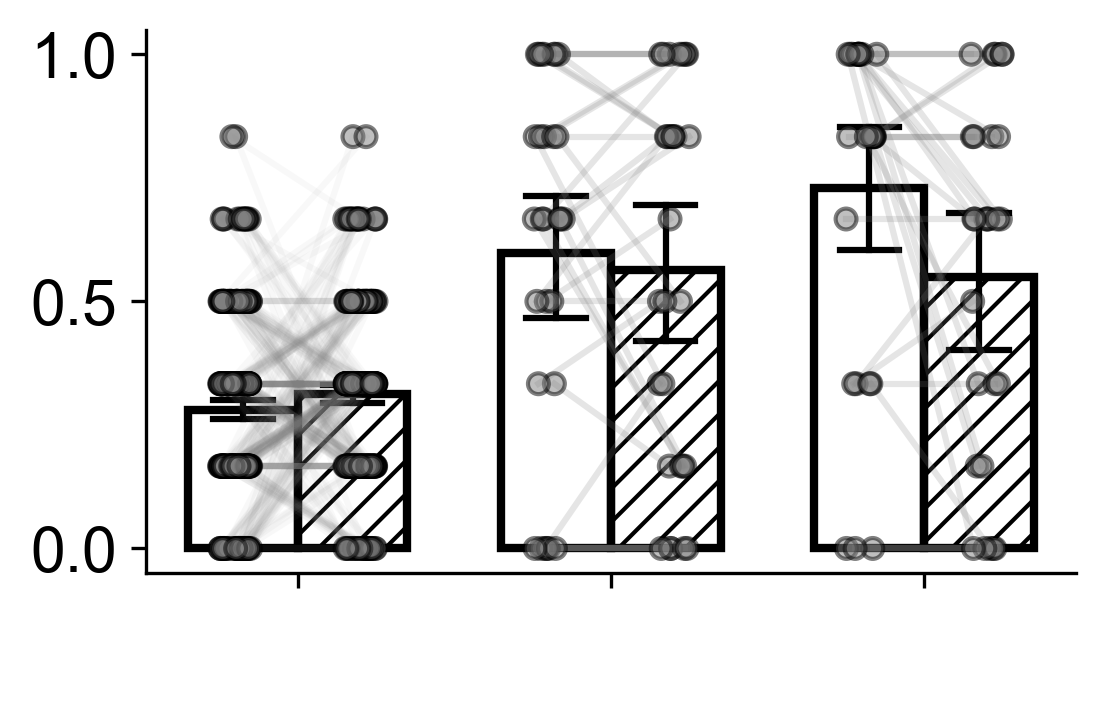

In [4]:
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 

attn_index = 0
df = {'proportion':[], 'type':[], 'subj':[]}
for total_proportion, subj in zip([model_proportion, native_proportion, l2_proportion],
                            ['model', 'en', 'zh']):
    for target_proportion in total_proportion:
        proportion = target_proportion[attn_index]
        
        df['proportion'].append(proportion[0] / 6)
        df['type'].append('structure 1')
        df['subj'].append(subj)
        
        df['proportion'].append(proportion[1] / 6)
        df['type'].append('structure 2')
        df['subj'].append(subj)

df = pd.DataFrame.from_dict(df)
fig, ax = plt.subplots(1, 1 , figsize=(4,2.4))
sns.set_context(rc = {'patch.linewidth': 2})
sns.despine(top=True, right=True, left=False, bottom=False)
g = sns.barplot(data = df, x='subj', y='proportion', hue='type', ax=ax, alpha=None,
                # palette=palette,
                errorbar = ('ci', 95),  
                estimator=np.mean, ci=95, capsize=.19, 
                errwidth=1.5, errcolor = 'k', 
                edgecolor='k', width=0.7
                )
for i, bar in enumerate(g.patches):

    color = '#1f77b4'
    color = 'white'
    bar.set_facecolor(to_rgba(color, 0.3))
    bar.set_edgecolor((0, 0, 0, 1))

g = sns.stripplot(
    data = df,
    x="subj", 
    y="proportion", 
    hue="type", 
    dodge=True, 
    alpha=0.5,
    # color = 'grey',
    # facecolors='grey',
    edgecolor='k', 
    palette = {'structure 1': 'grey', 
               'structure 2': 'grey'},
    linewidth=1,
    ax=ax,
    s=5,
    
)
a = ax.scatter([1,2],[3,4], marker='o')
b = ax.scatter([1,2],[3,4], marker='o')
square_mk, = a.get_paths()
triangle_up_mk, = b.get_paths()
a.remove()
b.remove()
N_hues = len(pd.unique(df.type))
c = ax.collections
for a in c[::N_hues]:
    a.set_paths([triangle_up_mk])
for a in c[1::N_hues]:
    a.set_paths([square_mk])

ax.legend(c[-2:],pd.unique(df.type))

idx0 = 24
idx1 = 25
locs1 = ax.get_children()[idx0].get_offsets()
locs2 = ax.get_children()[idx1].get_offsets()
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color='grey', alpha=0.05)
    

idx0 = 26
idx1 = 27
locs1 = ax.get_children()[idx0].get_offsets()
locs2 = ax.get_children()[idx1].get_offsets()
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color='grey', alpha=0.2)
    
idx0 = 28
idx1 = 29
locs1 = ax.get_children()[idx0].get_offsets()
locs2 = ax.get_children()[idx1].get_offsets()
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color='grey', alpha=0.2)

hatches = ['', '', '', '///', '///', '///']

for i,thisbar in enumerate(g.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
    # thisbar.set_edgecolor('red')
plt.ylim([-0.05,1.05])
plt.ylabel("")
plt.xlabel(r"   ")
g.set(xticklabels=[])

plt.legend([],[], frameon=False)

if attn_index == 0:
    print("significance test for adjunct attachment")
else:
    print("significance test for pp attachment")
print("="*50)

a = df[df['subj']=='model'][df['type']=='structure 1']['proportion'].values
b = df[df['subj']=='model'][df['type']=='structure 2']['proportion'].values
print('model paired bootstrap: ', paired_bootstrap_test(a, b))

a = df[df['subj']=='en'][df['type']=='structure 1']['proportion'].values
b = df[df['subj']=='en'][df['type']=='structure 2']['proportion'].values
print('native speaker paired bootstrap: ', paired_bootstrap_test(a, b))

a = df[df['subj']=='zh'][df['type']=='structure 1']['proportion'].values
b = df[df['subj']=='zh'][df['type']=='structure 2']['proportion'].values
print('l2 speaker paired bootstrap: ', paired_bootstrap_test(a, b))